In [1]:
# Basic packages.
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
tf.config.run_functions_eagerly(True)

# Visualization packages.
import seaborn as sns
import matplotlib.pyplot as plt

# Necessary variables for file exploration.
DATA_DIR = 'data'
TRANSFORMED_DIR = 'transformed'
feature_file = 'transformed_features.csv'
response_file = 'transformed_responses.csv'

# Read in the data.
feature_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, feature_file))
response_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, response_file))
feature_df.shape, response_df.shape

# Convert date to str & set as index.
feature_df['DATE'] = pd.to_datetime(feature_df['DATE'])
feature_df.set_index('DATE', drop=True, inplace=True)
response_df['Date'] = pd.to_datetime(response_df['Date'])
response_df.set_index('Date', drop=True, inplace=True)

# Normalize data frame.
normalized_df = (feature_df - feature_df.mean()) / feature_df.std()

# Perform a train-test split. Looking at the above data, let's train on all data prior to end of year 2005.
# Test on all data from 2005 to end of year 2019
# Keep beginning of 2020 through 2021 seperate for analysis and comparisons with other methods.
dates = np.array(feature_df.index)
# Add 1 to include December as a part of the train.
training_ends = np.where(dates == pd.to_datetime("2009-12-01"))[0][0] + 1
test_ends = np.where(dates == pd.to_datetime("2019-12-01"))[0][0] + 1
X_train, X_test, X_analysis = normalized_df.iloc[:training_ends, :], normalized_df.iloc[training_ends:test_ends, :], normalized_df.iloc[test_ends:, :]
y_train, y_test, y_analysis = response_df['Equity Indices Market'].iloc[:training_ends], response_df['Equity Indices Market'].iloc[training_ends:test_ends], response_df['Equity Indices Market'].iloc[test_ends:]
X_train.shape, X_test.shape, X_analysis.shape

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def graphHistory(history, title):
    """
    Function for graphing the training and valiedation accuracy and loss
    ...
    :param history - history object from keras desired to plot.
    :param title - str that will be the title of the resulting plot.
    """
    # summarize history for accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    #axes[0].title('Model Accuracy ' + title)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Tr. Acc', 'Val. Acc'])

    # summarize history for loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    #axes[1].title('Model Loss ' + title)
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Tr. Loss', 'Val. Loss'])
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Do the data transformations...
n_steps = 12
lstm_X_train, lstm_y_train = split_sequence(y_train.values, n_steps)
lstm_X_test, lstm_y_test = split_sequence(y_test.values, n_steps)
print(lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape)

# Reshape from (samples, timesteps) to (samples, timesteps, features)
n_features = 1
lstm_X_train = lstm_X_train.reshape((lstm_X_train.shape[0], lstm_X_train.shape[1], n_features))
lstm_X_test = lstm_X_test.reshape((lstm_X_test.shape[0], lstm_X_test.shape[1], n_features))
print(lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape)

(204, 12) (204,) (108, 12) (108,)
(204, 12, 1) (204,) (108, 12, 1) (108,)


2021-09-06 15:57:36.149978: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               20800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/7 [===>..........................] - ETA: 0s - loss: 14.8415 - accuracy: 0.0000e+00

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2021-09-06 15:57:36.429352: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


7/7 [==============================] - 0s 58ms/step - loss: 21.6028 - accuracy: 0.0000e+00 - val_loss: 9.9747 - val_accuracy: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 0s 62ms/step - loss: 21.2706 - accuracy: 0.0000e+00 - val_loss: 9.8909 - val_accuracy: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 0s 60ms/step - loss: 21.1623 - accuracy: 0.0000e+00 - val_loss: 9.8725 - val_accuracy: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 0s 63ms/step - loss: 21.0756 - accuracy: 0.0000e+00 - val_loss: 9.8784 - val_accuracy: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 0s 60ms/step - loss: 20.9431 - accuracy: 0.0000e+00 - val_loss: 9.8940 - val_accuracy: 0.0000e+00
Epoch 6/100
7/7 [==============================] - 0s 53ms/step - loss: 20.7669 - accuracy: 0.0000e+00 - val_loss: 9.9169 - val_accuracy: 0.0000e+00
Epoch 7/100
7/7 [==============================] - 0s 60ms/step - loss: 20.5543 - accuracy: 0.0000e+00 - val_loss: 9.9

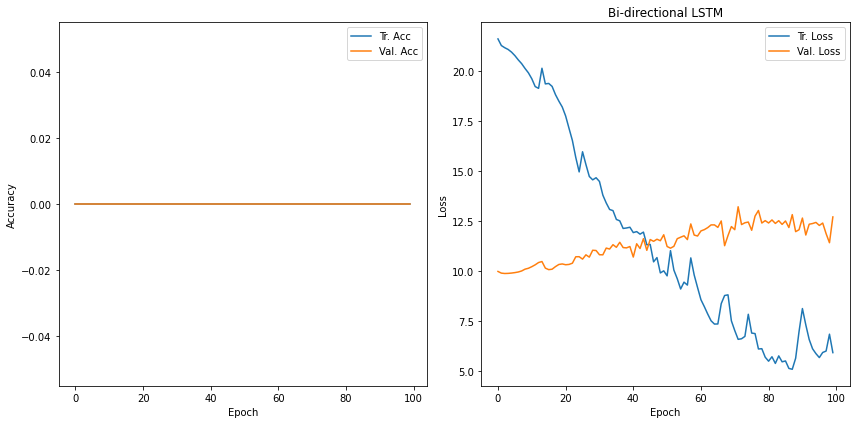

In [2]:
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse', metrics='accuracy')
model.summary()

# Train and graph history...
history = model.fit(lstm_X_train, lstm_y_train, epochs=100, validation_data=(lstm_X_test, lstm_y_test), shuffle=False)
graphHistory(history, 'Bi-directional LSTM')

In [3]:
# define a fx. to split a multivariate sequence into samples
def split_sequences_mv(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [4]:
# Concat the X_train and y_train
dataset = np.hstack((X_train.values, y_train.values.reshape((y_train.shape[0], 1))))
test_data = np.hstack((X_test.values, y_test.values.reshape((y_test.shape[0], 1))))
X_train.shape, y_train.shape, dataset.shape, type(dataset)

((216, 58), (216,), (216, 59), numpy.ndarray)

In [5]:
# Do the data transformations...
n_steps = 12
multi_X_train, multi_y_train = split_sequences_mv(dataset, n_steps)
multi_X_test, multi_y_test = split_sequences_mv(test_data, n_steps)
print(multi_X_train.shape, multi_y_train.shape, multi_X_test.shape, multi_y_test.shape)

(205, 12, 58) (205,) (109, 12, 58) (109,)


In [6]:
# define model
n_features = 58
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, kernel_initializer='he_normal', activation='relu'), input_shape=(n_steps, n_features)))
model.add(tf.keras.layers.LSTM(32, kernel_initializer='he_normal', activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse', metrics='accuracy')
model.summary()

# Train and graph history...
history = model.fit(multi_X_train, multi_y_train, epochs=100, validation_data=(multi_X_test, multi_y_test), shuffle=False)
graphHistory(history, 'Bi-directional LSTM')

ValueError: Input 0 of layer lstm_2 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 100)